In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.optimizers import Adam

In [5]:
data = pd.read_csv('dataset_rate.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,rate
0,2022-01-14,1.0938
1,2022-01-15,1.0938
2,2022-01-16,1.0934
3,2022-01-17,1.0941
4,2022-01-18,1.0903


In [6]:
min_max_scaler = MinMaxScaler()
data['normalized_rate'] = min_max_scaler.fit_transform(data[['rate']])
data.head()

,date,rate,normalized_rate
0,2022-01-14,1.0938,0.596433
1,2022-01-15,1.0938,0.596433
2,2022-01-16,1.0934,0.594203
3,2022-01-17,1.0941,0.598105
4,2022-01-18,1.0903,0.576923


In [7]:
def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)


look_back = 7
train_size = int(len(data) * 0.8)
train_data, test_data = data[0:train_size], data[train_size:len(data)]
X_train, y_train = create_dataset(train_data['normalized_rate'].values, look_back)
X_test, y_test = create_dataset(test_data['normalized_rate'].values, look_back)

In [8]:
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                               verbose=1,
                               callbacks=[early_stopping,
                                          model_checkpoint])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0083 - val_loss: 0.0017
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 8.1340e-04
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 6.8633e-04
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 7.1506e-04
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 6.5973e-04
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 6.7800e-04
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 6.3032e-04
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

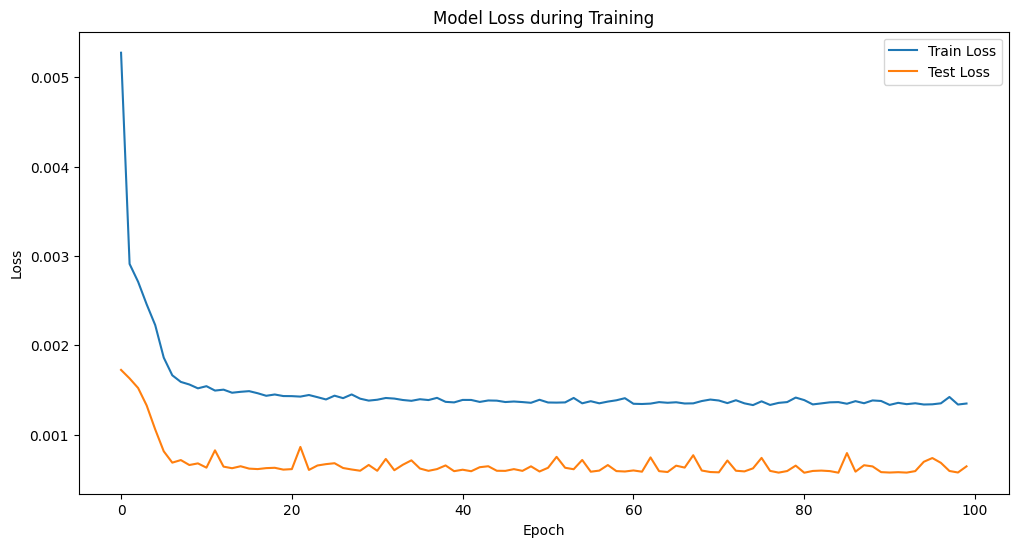

In [9]:
def plot_history(training_history):
    plt.figure(figsize=(12, 6))
    plt.plot(training_history.history['loss'], label='Train Loss')
    plt.plot(training_history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss during Training')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
plot_history(history)

In [11]:
best_model = load_model('best_model.keras')
val_loss = best_model.evaluate(X_test, y_test)
print(f'Validation loss: {val_loss:.5f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7329e-04 
Validation loss: 0.00057


In [12]:
def plot_predictions(model, X_data, Y_data):
    plt.figure(figsize=(12, 6))
    y_pred_scaled = model.predict(X_data)
    y_pred = min_max_scaler.inverse_transform(y_pred_scaled)
    actual_rate = min_max_scaler.inverse_transform(Y_data.reshape(-1, 1))
    plt.plot(actual_rate, label='Actual Rate')
    plt.plot(y_pred, label='Predicted Rate')
    plt.legend()
    plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


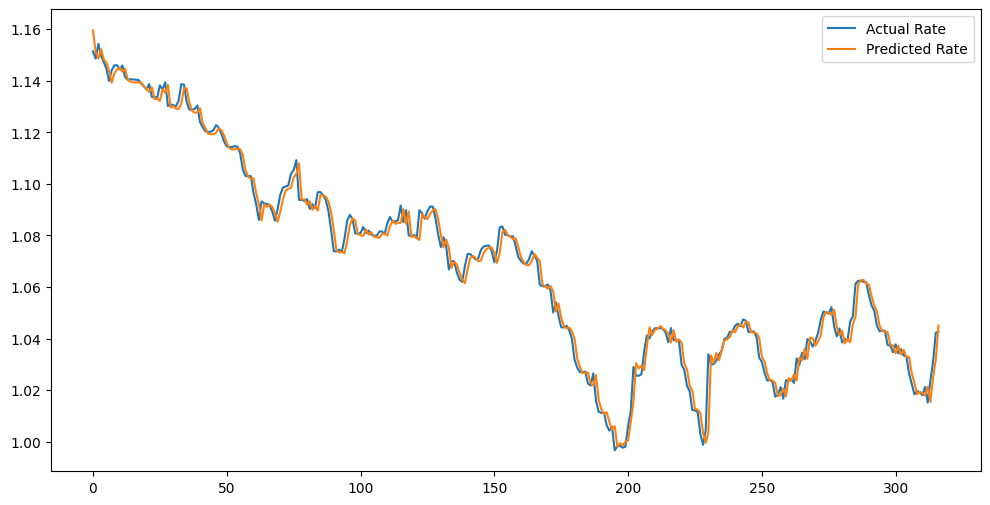

In [13]:
plot_predictions(best_model, X_test, y_test)